In [1]:
import os
import polars as pl
import pandas as pd
import numpy as np
from functools import partial
import dproc, sgutil

import seaborn as sns
import matplotlib.pyplot as plt

import shap

In [2]:
data_path = 'data'
if not os.path.isdir(data_path):
    os.mkdir(data_path)
files = {
    k: os.path.join(p, f)
    for k, p, f in [
        ('train', data_path, 'train.csv'),
        ('test', data_path, 'test.csv'),
        ('org_train', data_path, 'train_org.csv'),
        ('org_test', data_path, 'test_org.csv'),
        ('train_parquet', data_path, 'train.parquet'),
        ('org_pkl', data_path, 'org.pkl'),
        ('test_parquet', data_path, 'test.parquet'),
        ('var_pkl', data_path, 'var.pkl')
    ]
}

if (not os.path.isfile(files['train'])) and (not os.path.isfile(files['var_pkl'])):
    !kaggle competitions download -c playground-series-s4e7
    !mkdir data
    !unzip playground-series-s4e7.zip -d data
    !rm playground-series-s4e7.zip
    !kaggle datasets download -d annantkumarsingh/health-insurance-cross-sell-prediction-data
    !unzip health-insurance-cross-sell-prediction-data.zip
    !mv train.csv data/train_org.csv
    !mv test.csv data/test_org.csv
    !rm health-insurance-cross-sell-prediction-data.zip

In [3]:
if not os.path.exists(files['var_pkl']):
    from io import StringIO
    vars = StringIO(
    """Age	(continous)	Age of the Customer.
    Gender	(dichotomous)	Gender of the Customer.
    Driving_License	(dichotomous)	0 for customer not having DL, 1 for customer having DL.
    Region_Code	(nominal)	Unique code for the region of the customer.
    Previously_Insured	(dichotomous)	0 for customer not having vehicle insurance, 1 for customer having vehicle insurance.
    Vehicle_Age	(nominal)	Age of the vehicle.
    Vehicle_Damage	(dichotomous)	Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.
    Annual_Premium	(continous)	The amount customer needs to pay as premium in the year.
    Policy_Sales_Channel	(nominal)	Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
    Vintage	(continous)	Number of Days, Customer has been associated with the company.
    Response (Dependent Feature)	(dichotomous)	1 for Customer is interested, 0 for Customer is not interested."""
    )
    df_var = pd.read_csv(vars, sep='\t', header=None).rename(
        columns={0: 'name', 1: 'type', 2: 'Description'}
    )
    df_var.head()
    df_type = dproc.merge_type_df([
        pl.scan_csv(files[i]).pipe(dproc.get_type_df) for i in ['train', 'test', 'org_train', 'org_test']
    ])
    # Region_Code to category, Policy_Sales_Channel to category
    pl_type = dproc.get_type_pl(df_type, {'Region_Code': pl.Categorical, 'Policy_Sales_Channel': pl.Categorical, 'Previously_Insured': pl.Categorical})
    s_type = pd.Series(pl_type).astype(str).rename('dtype')
    df_var = df_var.set_index('name').rename(columns={'type': 'var_type'}).join(df_type.drop(columns='dtype')).join(s_type)
    pl.scan_csv('data/train.csv', schema_overrides = pl_type).sink_parquet(files['train_parquet'])
    pl.scan_csv('data/test.csv', schema_overrides = pl_type).sink_parquet(files['test_parquet'])
    df_var.to_pickle(files['var_pkl'])
    !rm data/train.csv
    !rm data/test.csv
sc = sgutil.SGCache('img', 'result')
df_var = pd.read_pickle(files['var_pkl']).assign(src="org")
df_var

,var_type,Description,min,max,na,count,n_unique,f32,i32,i16,i8,dtype,src
name,,,,,,,,,,,,,
Age,(continous),Age of the Customer.,20.0,85.0,0.0,19682810.0,66.0,True,True,True,True,Int8,org
Gender,(dichotomous),Gender of the Customer.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,org
Driving_License,(dichotomous),"0 for customer not having DL, 1 for customer h...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,org
Region_Code,(nominal),Unique code for the region of the customer.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,org
Previously_Insured,(dichotomous),"0 for customer not having vehicle insurance, 1...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,org
Vehicle_Age,(nominal),Age of the vehicle.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,org
Vehicle_Damage,(dichotomous),Customer got his/her vehicle damaged in the pa...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,org
Annual_Premium,(continous),The amount customer needs to pay as premium in...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,org
Policy_Sales_Channel,(nominal),Anonymized Code for the channel of outreaching...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,org


# Polars Processing

In [4]:
dprocs = list()
df_train = pl.read_parquet(files['train_parquet'])
df_test = pl.read_parquet(files['test_parquet'])

mode_AnnualPremium = df_train['Annual_Premium'].mode()[0]
mean_Annual_Premium_without_mode = df_train.filter(pl.col('Annual_Premium') != mode_AnnualPremium)['Annual_Premium'].mean()
proc_list=[
    ('is_Annual_Premium_mode', pl.when(pl.col('Annual_Premium') == mode_AnnualPremium).then(1).otherwise(0).cast(pl.Int8), 'Annual_Premium의 최빈값 여부'),
]

In [5]:
df_train, df_var = dproc.apply_with_columns(df_train, dprocs, 'mode')
df_train = df_train.to_pandas().set_index('id')
df_test = dproc.apply_with_columns(df_test, dprocs)
df_test = df_test.to_pandas().set_index('id')
target = 'Response'

In [6]:
pd_procs = dproc.PD_Vars.load_or_create(os.path.join('data', 'vars') , df_var)

# Categorical Data Processing

In [7]:
sc.cache_result('cat_vals_not_in_train',
    lambda : pd.concat([
        df_train[['Policy_Sales_Channel', 'Region_Code', 'Vintage']].apply(set, axis=0, raw=True).rename('train'),
        df_test[['Policy_Sales_Channel', 'Region_Code', 'Vintage']].apply(set, axis=0, raw=True).rename('test')
    ], axis=1).apply(
        lambda x: x['test'] - x['train'], axis=1
    )
)

Policy_Sales_Channel    {149.0, 144.0}
Region_Code                         {}
Vintage                             {}
dtype: object

In [8]:
def get_nearest_c_proc(df, col, min_cnt = 5):   
    s_cat_count = df[col].value_counts().pipe(lambda x: x.loc[x >= min_cnt])
    cat_vals = s_cat_count.sort_index().index
    cat_c_type = pd.CategoricalDtype(cat_vals, ordered=True)
    return lambda x: dproc.replace_cat(
        dproc.rearrange_cat(
            x[col].astype('category'), cat_c_type, lambda cat_vals, x: np.argmin(np.abs(cat_vals - x))
        ), lambda y: str(y)
    ).rename('{}_S'.format(col))

def get_categ_proc(df):
    region_c_type = pd.CategoricalDtype(dproc.replace_cat(df['Region_Code'], {'39.2': '39.0'}).unique())
    s_cnt = df['Policy_Sales_Channel'].value_counts().pipe(lambda x: x.loc[x > 10])
    policy_sales_channel_c_type = pd.CategoricalDtype(['etc'] + s_cnt.index.tolist())
    return lambda x: pd.concat([
        dproc.replace_cat(x['Region_Code'], {'39.2': '39.0'}).astype(region_c_type).rename('Region_Code_S'),
        dproc.rearrange_cat(x['Policy_Sales_Channel'], policy_sales_channel_c_type, lambda c, v: 0 if v not in c else v).rename('Policy_Sales_Channel_S'),
    ], axis=1)

cat_proc_list = sc.cache_result(
    'cat_proc_list',
    lambda : [
        (get_nearest_c_proc(df_train, 'Annual_Premium', min_cnt=5), "Annual_Premium의 범주형 변수"),
        (get_nearest_c_proc(df_train, 'Vintage'), "Vintage의 범주형 변수"),
        (get_nearest_c_proc(df_train, 'Age'), "Age의 범주형 변수"),
        (get_categ_proc(df_train), {'Region_Code_S': 'Region_Code를 범주형 변수', 'Policy_Sales_Channel_S': 'Policy_Sales_Channel의 범주형 변수'})
    ]
)
df_train = pd_procs.put_proc('cat_proc', df_train, cat_proc_list)

In [9]:
pd_procs.save()

# Categorical Data

In [10]:
from scipy.stats import chi2_contingency

s_chi2_result = sc.cache_result(
    'chi2_test',
    lambda : df_train[['Vehicle_Age', 'Vehicle_Damage', 'Region_Code_S', 'Policy_Sales_Channel_S', 'Vintage_S', 'Annual_Premium_S', 'Age_S', 
                       'Previously_Insured', 'Driving_License', 'Gender']].apply(
        lambda x: chi2_contingency(
            pd.crosstab(index=x, columns=df_train[target])
        )[0]
    )
)
s_chi2_result.sort_values(ascending=False).rename('Chi2-statistic').to_frame().T

,Vehicle_Damage,Previously_Insured,Policy_Sales_Channel_S,Annual_Premium_S,Age_S,Vehicle_Age,Vintage_S,Region_Code_S,Gender,Driving_License
Chi2-statistic,1.489196e+06,1.376748e+06,849212.934678,848216.028935,701977.770434,614768.206138,327749.404281,260136.125714,35070.871592,972.499672


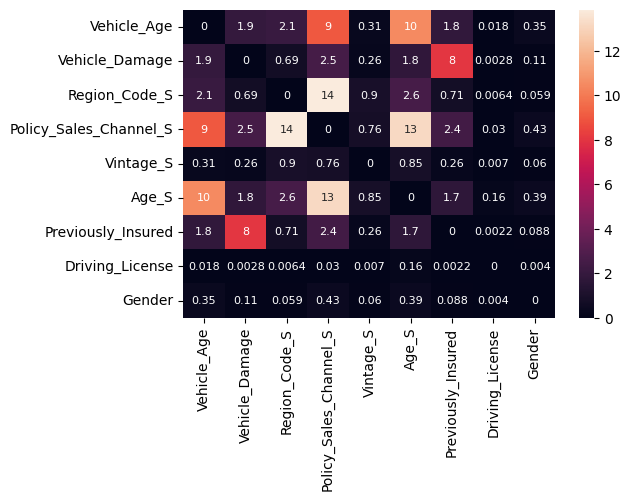

In [11]:
from scipy.spatial.distance import pdist, squareform
pair_chi2 = ['Vehicle_Age', 'Vehicle_Damage', 'Region_Code_S', 'Policy_Sales_Channel_S', 'Vintage_S', 'Age_S', 'Previously_Insured', 'Driving_License', 'Gender']
df_chi2_pair = sc.cache_result(
    'chi2_pairs',
    lambda : pdist(
        df_train[pair_chi2].T, 
        lambda u, v: chi2_contingency(pd.crosstab(index=u, columns=v))[0]
    )
)
plt.figure(figsize=(6, 4))
sns.heatmap(
    pd.DataFrame(squareform(df_chi2_pair), index=pair_chi2,columns=pair_chi2) / 1e6, annot=True, annot_kws={'fontsize': 8}
)
plt.show()

In [12]:
s_chi2_annual = sc.cache_result(
    'chi2_annual',
    lambda : df_train[pair_chi2].apply(
        lambda x: chi2_contingency(
            pd.crosstab(index=x, columns=df_train[target])
        ), axis=0
    )
).apply(lambda x: x[0]) / 1e6
s_chi2_annual.sort_values(ascending=False).to_frame().T

,Vehicle_Damage,Previously_Insured,Policy_Sales_Channel_S,Age_S,Vehicle_Age,Vintage_S,Region_Code_S,Gender,Driving_License
0,1.489196,1.376748,0.849213,0.701978,0.614768,0.327749,0.260136,0.035071,0.000972


In [13]:
pd.concat([
    df_train.groupby(['Vehicle_Damage',  'Previously_Insured'], observed=True)[target].size().rename('count'),
    df_train.groupby(['Vehicle_Damage',  'Previously_Insured'], observed=True)[target].sum().rename('sum'),
    df_train.groupby(['Vehicle_Damage',  'Previously_Insured'], observed=True)[target].mean().rename('ratio'),
], axis=1)

count      sum     ratio
Vehicle_Damage Previously_Insured                            
Yes            0                   5504102  1389217  0.252397
               1                    279127     1821  0.006524
No             0                    674014    22442  0.033296
               1                   5047555     1579  0.000313

# Continuous Data

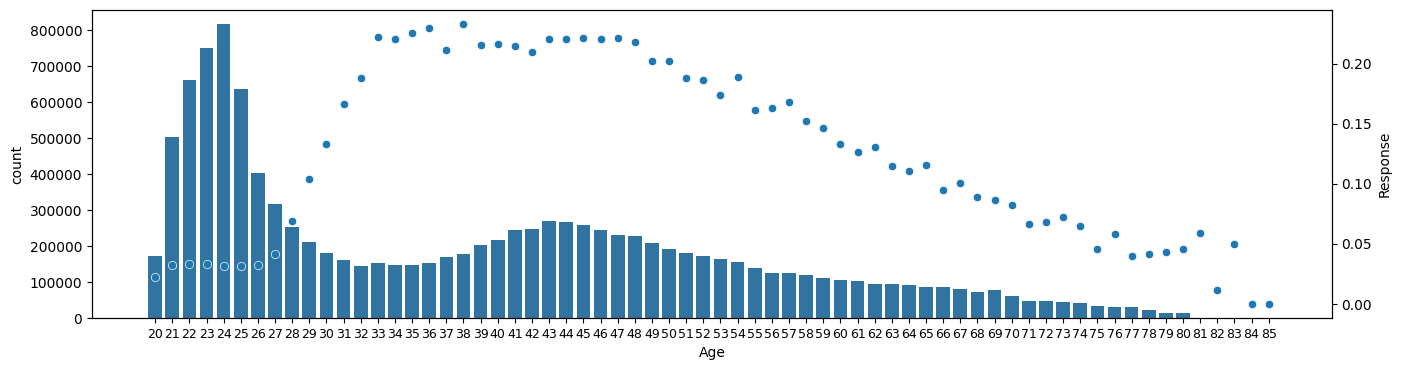

In [14]:
plt.figure(figsize=(16, 4))
sns.barplot(df_train['Age'].value_counts())
plt.gca().tick_params(axis='x', which='major', labelsize=9)
sns.scatterplot(df_train.groupby('Age')[target].mean().reset_index(drop=True), ax=plt.gca().twinx())
plt.show()

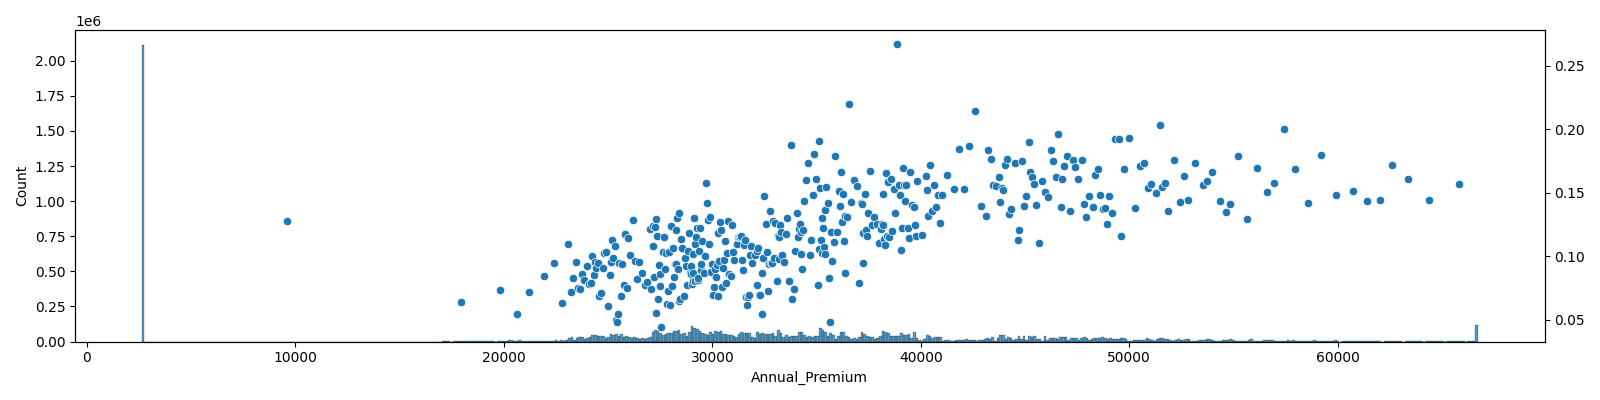

In [15]:
def show_annual_premium(ax):
    s_clip = df_train['Annual_Premium'].clip(0, df_train['Annual_Premium'].quantile(0.99))
    sns.histplot(s_clip, ax=ax)
    df_train.groupby(pd.qcut(s_clip, 500, duplicates='drop'), observed=True)[target].mean().pipe(
        lambda x: sns.scatterplot(x = x.index.map(lambda x: (x.left + x.right) * 0.5), y = x.values, ax=ax.twinx())
    )
sc.cache_fig('annual_premium_fig', lambda x: show_annual_premium(x), 1, 1, figsize=(16, 4))

In [16]:
from scipy.stats import spearmanr
from scipy.stats import mannwhitneyu

s_annual_premium = sc.cache_result(
    'annual_premium_stat',
    lambda : pd.Series([
        df_train.groupby(pd.qcut(df_train['Annual_Premium'], 500, duplicates='drop'), observed=True)[target].mean().pipe(
            lambda x: spearmanr(x.index.map(lambda x: (x.left + x.right) * 0.5), x.values)
        ),
        mannwhitneyu(*df_train.groupby(target)['Annual_Premium'].agg(list))[0],
    ], index=['spearman_corr_with_prob', 'manwhitneyu-stat-Annual_Premium'])
)
s_annual_premium.to_frame().T

,spearman_corr_with_prob,manwhitneyu-stat-Annual_Premium
0,"(0.7670440553823056, 1.846609403877403e-80)",6520667707045.0


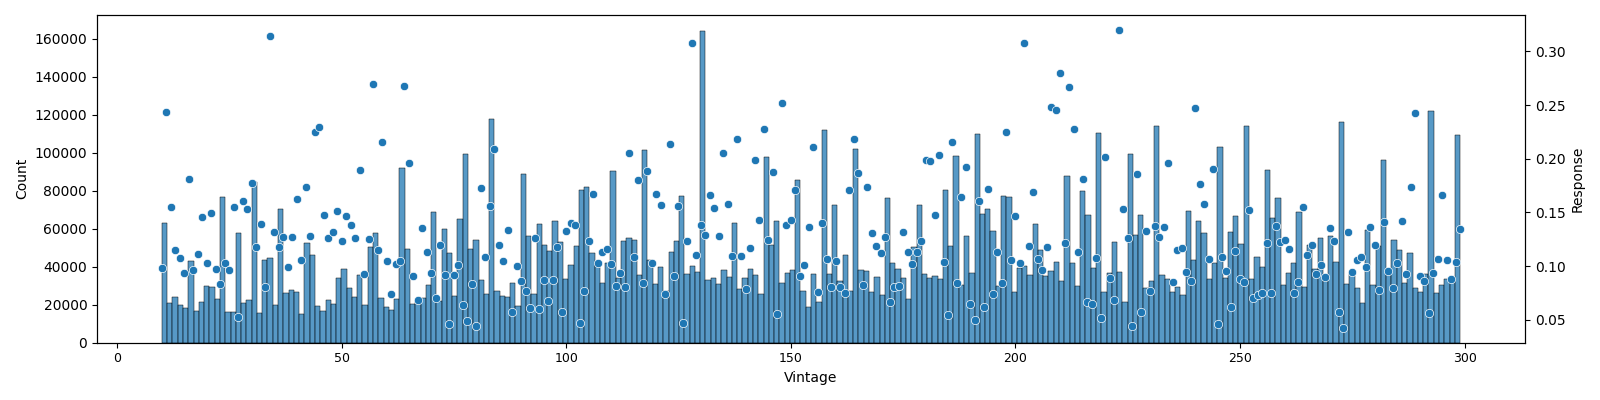

In [17]:
def show_vintage(ax):
    sns.histplot(df_train['Vintage'], ax=ax)
    ax.tick_params(axis='x', which='major', labelsize=9)
    sns.scatterplot(df_train.groupby('Vintage')[target].mean(), ax=ax.twinx())
sc.cache_fig(
    'vintage_fig', show_vintage, 1, 1, (16, 4)
)         

In [18]:
s_vintage = sc.cache_result(
    'vintage_stat',
    lambda : pd.Series([
        df_train.groupby('Vintage', observed=True)[target].mean().pipe(
            lambda x: spearmanr(x.index, x.values)
        ),
        mannwhitneyu(*df_train.groupby(target)['Vintage'].agg(list))[0],
    ], index=['spearman_corr_with_prob', 'manwhitneyu-stat'])
)
s_vintage.to_frame().T

,spearman_corr_with_prob,manwhitneyu-stat
0,"(-0.09089853460884155, 0.12247699537889553)",7326595875460.0


In [19]:
df_train.groupby(target)['Vintage'].median()

Response
0    167.0
1    164.0
Name: Vintage, dtype: float64

# Analysis through ML Models

In [20]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import TargetEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import sgml

def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size=validation_fraction, stratify=x[target])

config = {
    'predict_func': lambda m, df, X: pd.Series(m.predict_proba(df[X])[:, 1], index=df.index),
    'score_func': lambda df, prds: roc_auc_score(df[target].sort_index(), prds.sort_index()),
    'validation_splitter': get_validation_splitter,
    'y': target,
}

lgb_adapter = sgml.LGBMAdapter(model=lgb.LGBMClassifier)
xgb_adapter = sgml.XGBAdapter(model=xgb.XGBClassifier) 
cb_adapter = sgml.CBAdapter(model=cb.CatBoostClassifier)
dt_adapter = sgml.SklearnAdapter(DecisionTreeClassifier)
lr_adapter = sgml.SklearnAdapter(LogisticRegression)


def print_metrics(title, m):
    print("Accuracy, {}: {:.5f}±{:.5f}".format(
        title, np.mean(m), np.std(m)
    ))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
ss = ShuffleSplit(n_splits=1, train_size=0.8, random_state=123)

## Logistic Regression

In [21]:
hparams = {
    'model_params': {},
    'X_tgt': ['Vintage_S', 'Annual_Premium_S'],
    'X_mm': ['Annual_Premium', 'Vintage'], 
    'X_ohe': ['Vehicle_Damage', 'Previously_Insured', 'Policy_Sales_Channel_S', 'Age_S', 'Vehicle_Age', 'Region_Code_S', 
              'Gender', 'Driving_License'],
    'ohe': {'drop': 'first', 'handle_unknown': 'ignore'},
    'tgt': {}
}

result = sc.cache_result(
    'LR1', 
    lambda : sgml.cv(df_train, ss, hparams, config, lr_adapter, result_proc=[sgml.lr_learning_result])
)

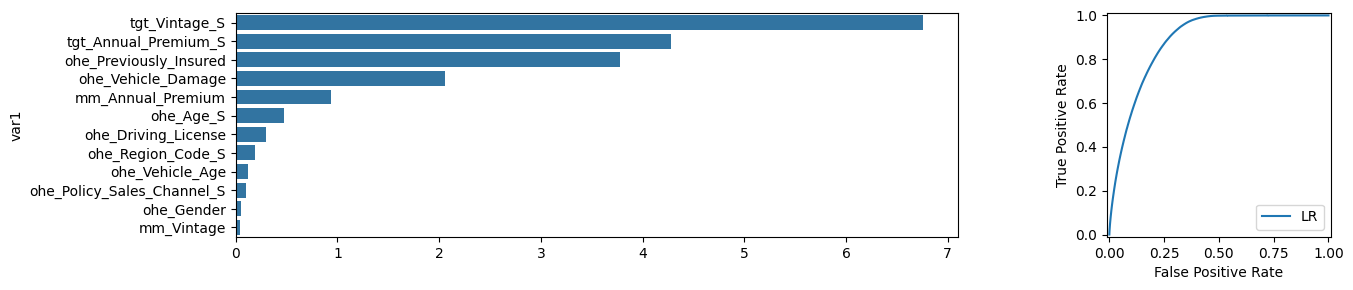

([0.8844394129787585], [0.8862555971242867])

In [22]:
from sklearn.metrics import RocCurveDisplay, roc_curve
s_coef = result['model_result'][0]['coef'][0]
s_vars = dproc.split_preprocess_var(s_coef.index.to_series(), pd_procs.df_var.index)['var1']
fig, axes = plt.subplots(1, 2, figsize=(16, 3))
s_coef.abs().groupby(s_vars).mean().sort_values(ascending=False).pipe(lambda x: sns.barplot(y=x.index, x=x.values, ax=axes[0]))
fpr, tpr, _ = roc_curve(df_train.loc[result['valid_prd'].index, target].values, result['valid_prd'].values)
RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name='LR').plot(ax=axes[1])
plt.tight_layout()
plt.show()
result['valid_scores'], result['train_scores']

## CatBoost

In [23]:
hparams = {
    'model_params': {'n_estimators': 50, 'learning_rate': 0.3, 'max_depth': 9},
    'X_num': ['Annual_Premium', 'Vintage', 'Age'], 
    'X_cat': ['Annual_Premium_S', 'Vintage_S', 'Vehicle_Damage', 'Previously_Insured', 'Policy_Sales_Channel_S', 'Age_S', 'Vehicle_Age', 'Region_Code_S', 
              'Gender', 'Driving_License'],
}

result = sc.cache_result(
    'CB1', 
    lambda : sgml.cv(df_train, ss,  hparams, config, cb_adapter, task_type='GPU', 
                     result_proc=[sgml.cb_learning_result, partial(sgml.gb_shap_learning_result, df=df_train.sample(frac=0.1)), sgml.cb_interaction_importance])
)
result['valid_scores'], result['train_scores']

([0.8888228722159518], [0.890672779656913])

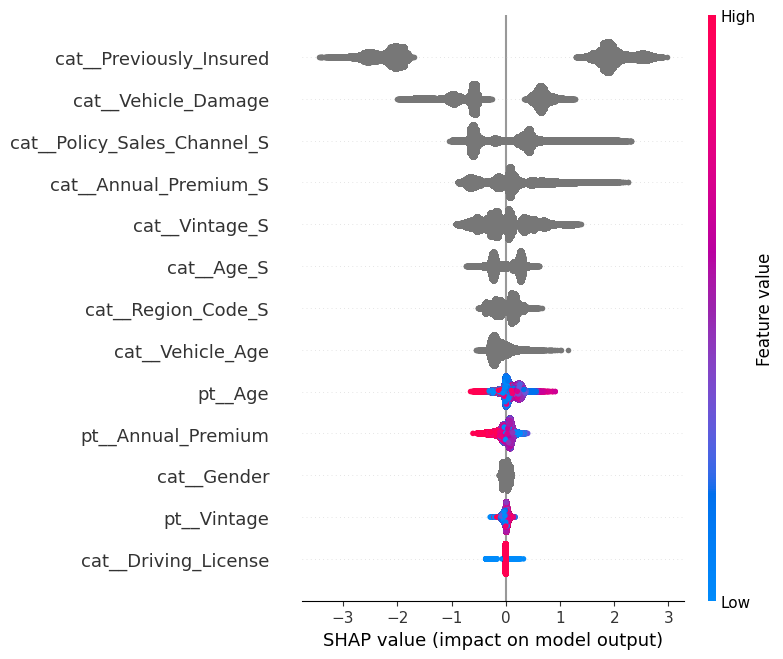

In [24]:
shap.summary_plot(result['model_result'][1]['shap_values'], result['model_result'][1]['X'])

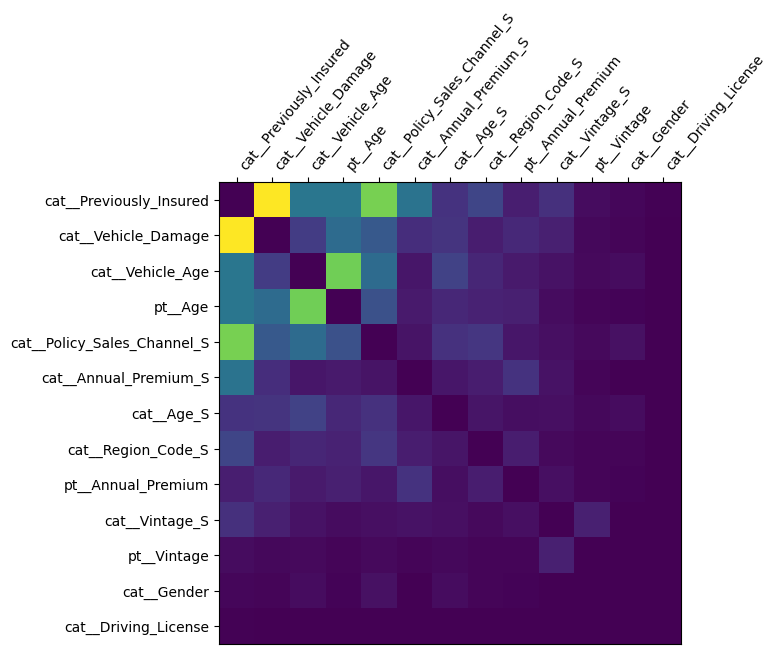

In [25]:
interaction_matrix = np.abs(result['model_result'][1]['shap_interaction_values']).sum(0)
for i in range(interaction_matrix.shape[0]):
    interaction_matrix[i, i] = 0
inds = np.argsort(-interaction_matrix.sum(0))[:20]
sorted_ia_matrix = interaction_matrix[inds, :][:, inds]
plt.figure(figsize=(10, 6))
plt.imshow(sorted_ia_matrix)
plt.yticks(
    range(sorted_ia_matrix.shape[0]),
    result['model_result'][1]['X'].columns[inds],
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(sorted_ia_matrix.shape[0]),
    result['model_result'][1]['X'].columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

# Previously_Insured & Vehicle_Damage

In [26]:
df_train['PV'] = (df_train['Previously_Insured'] == '0') & (df_train['Vehicle_Damage'] == 'Yes')

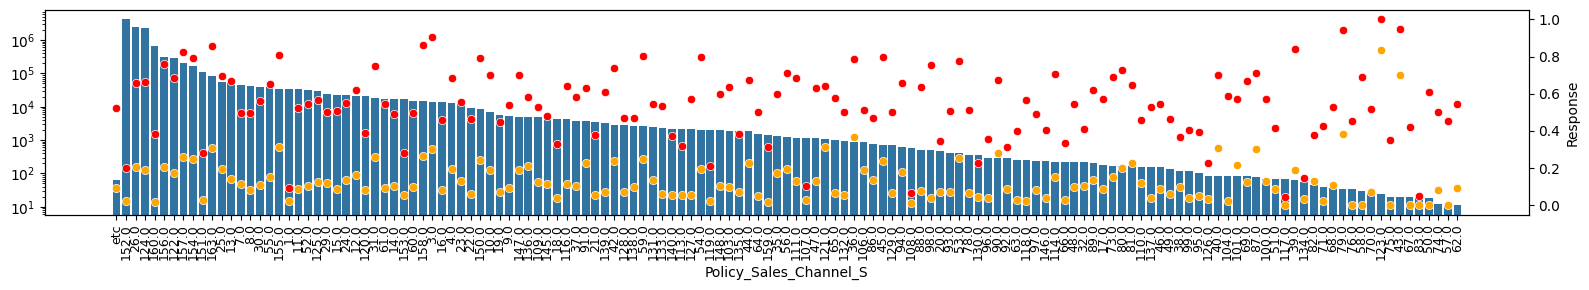

In [27]:
def policy_sales_1(ax):
    sns.barplot(df_train.groupby('Policy_Sales_Channel_S', observed=False).size(), ax=ax)
    ax.set_yscale('log')
    s_mean = df_train.groupby('Policy_Sales_Channel_S', observed=False)[target].mean()
    tax = ax.twinx()
    sns.scatterplot(s_mean.reset_index(drop=True), ax=tax, c='orange')
    s_mean = df_train.groupby('Policy_Sales_Channel_S', observed=False)['PV'].mean()
    sns.scatterplot(s_mean.reset_index(drop=True), ax=tax, c='red')
    ax.tick_params(axis='x', which='major', labelsize=9)
    ax.set_xticks(
        np.arange(len(s_mean)),
        s_mean.index,
        rotation=90,
    )
sc.cache_fig('policy_sales_1', policy_sales_1, 1, 1, figsize=(16, 3), redraw=1)

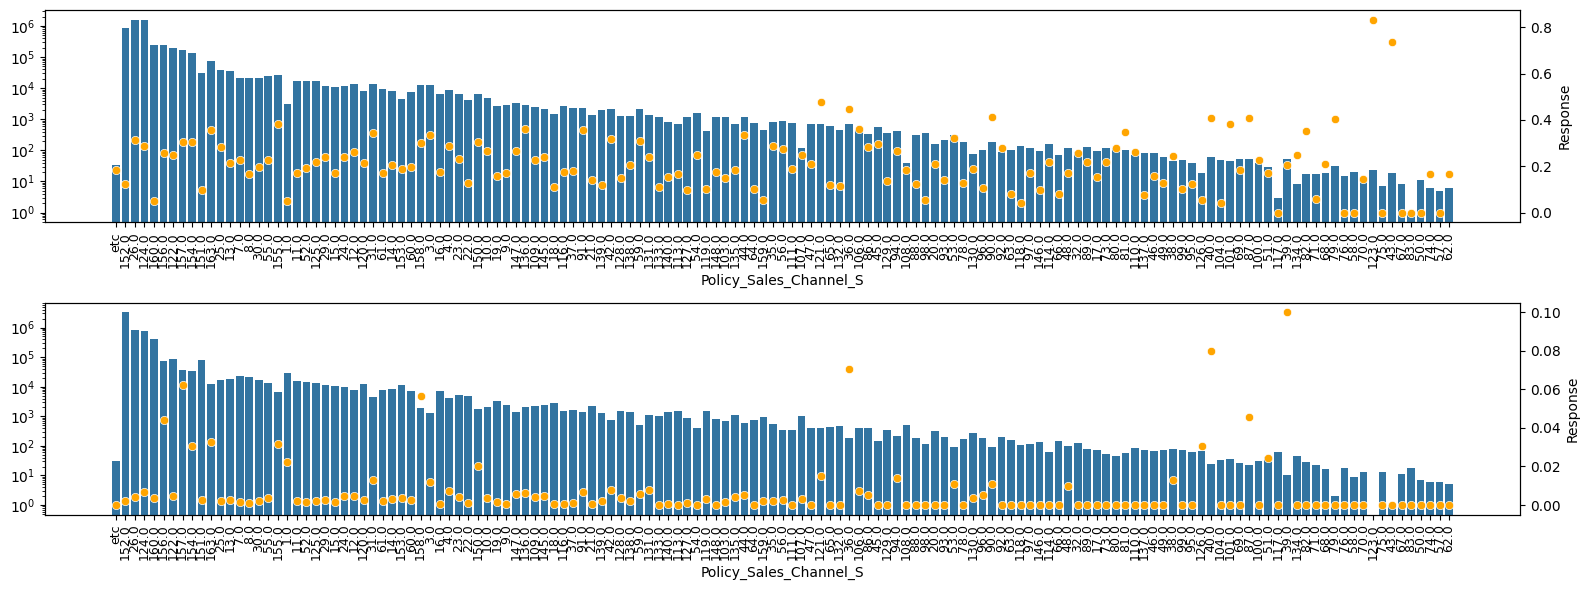

In [28]:
def policy_sales_2(axes):
    for idx, ax in zip([
            (df_train['Previously_Insured'] == '0') & (df_train['Vehicle_Damage'] == 'Yes'),
            ~((df_train['Previously_Insured'] == '0') & (df_train['Vehicle_Damage'] == 'Yes'))
        ], axes):
        df_sub = df_train.loc[idx]
        s_mean = df_sub.groupby('Policy_Sales_Channel_S', observed=False)[target].mean()
        sns.barplot(df_sub.groupby('Policy_Sales_Channel_S', observed=False).size(), ax=ax)
        ax.set_yscale('log')
        sns.scatterplot(s_mean.reset_index(drop=True), ax=ax.twinx(), c='orange')
        ax.tick_params(axis='x', which='major', labelsize=9)
        ax.set_xticks(
            np.arange(len(s_mean)),
            s_mean.index,
            rotation=90,
        )
sc.cache_fig('policy_sales_2', policy_sales_2, 2, 1, figsize=(16, 6), redraw=True)

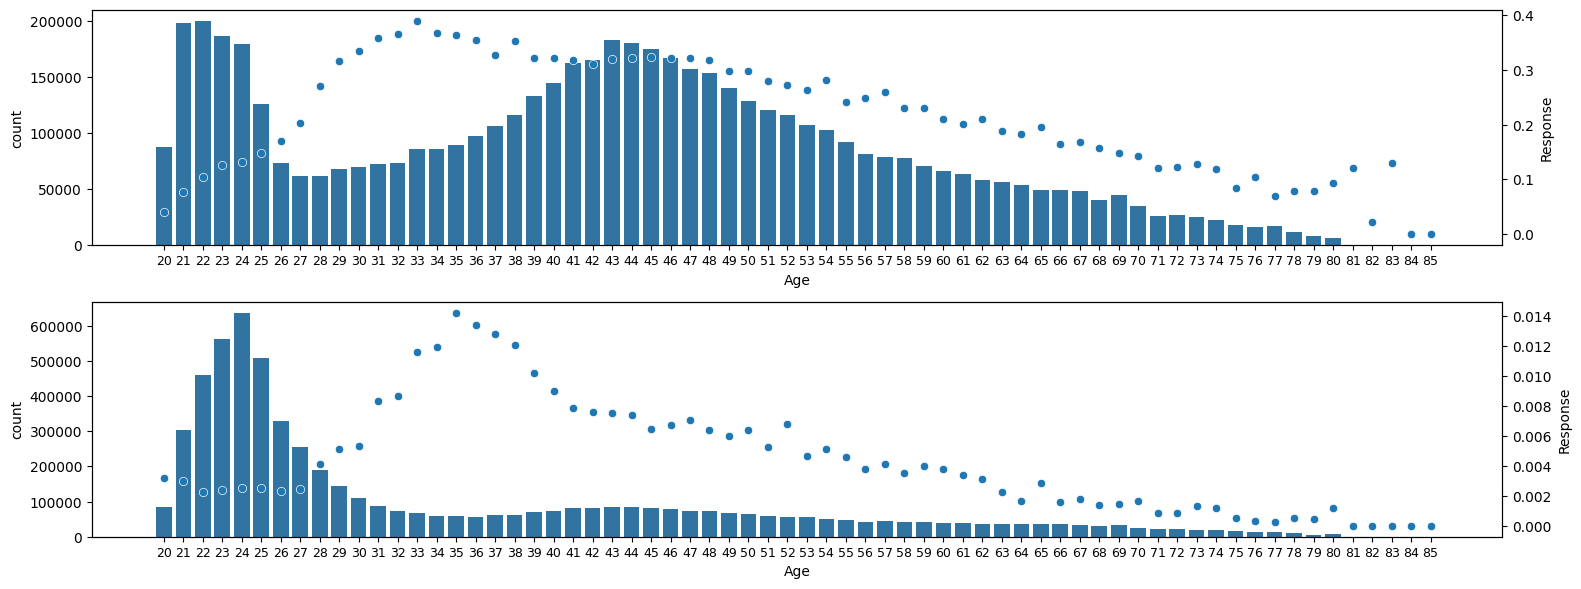

In [29]:
def age_2(axes):
    for idx, ax in zip([
            (df_train['Previously_Insured'] == '0') & (df_train['Vehicle_Damage'] == 'Yes'),
            ~((df_train['Previously_Insured'] == '0') & (df_train['Vehicle_Damage'] == 'Yes'))
        ], axes):
        df_sub = df_train.loc[idx]
        sns.barplot(df_sub['Age'].value_counts(), ax=ax)
        ax.tick_params(axis='x', which='major', labelsize=9)
        sns.scatterplot(df_sub.groupby('Age')[target].mean().reset_index(drop=True), ax=ax.twinx())
sc.cache_fig('age_2', age_2, 2, 1, figsize=(16, 6))

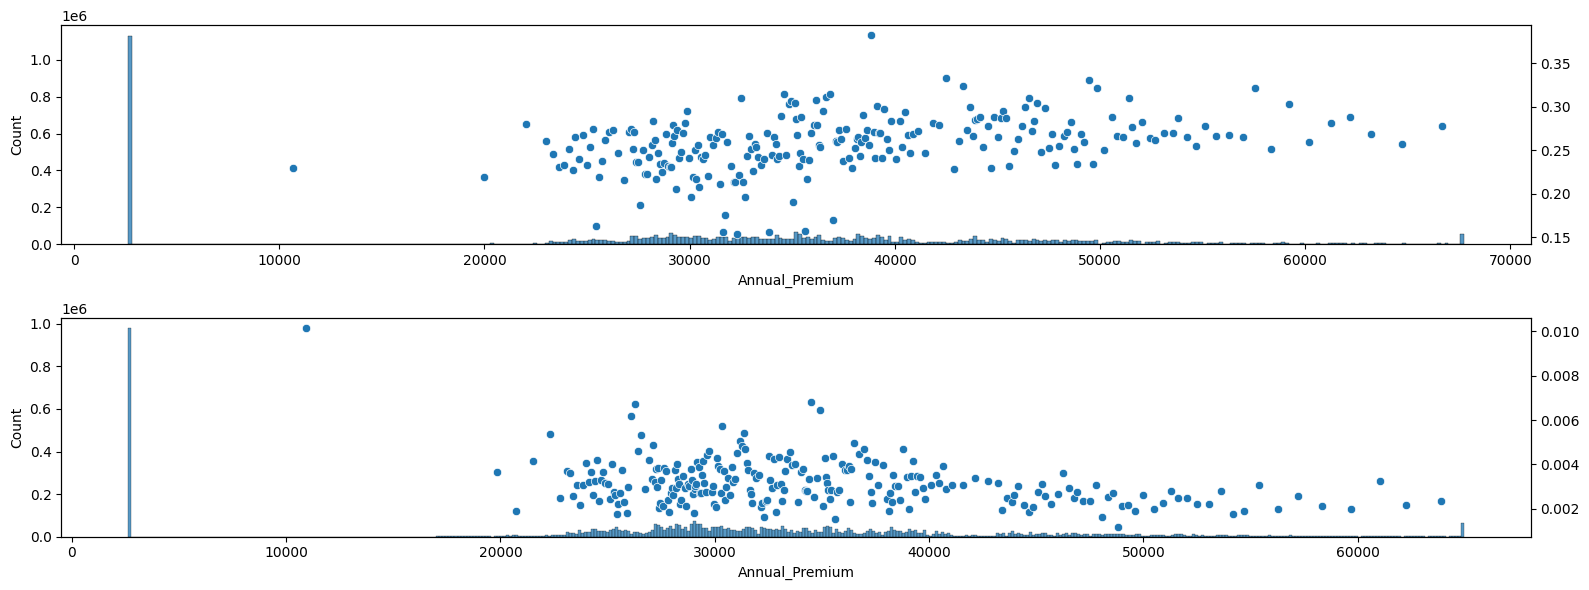

In [32]:
from scipy.stats import pearsonr
def annual_2(axes):
    for idx, ax in zip([
            (df_train['Previously_Insured'] == '0') & (df_train['Vehicle_Damage'] == 'Yes'),
            ~((df_train['Previously_Insured'] == '0') & (df_train['Vehicle_Damage'] == 'Yes'))
        ], axes):
        df_sub = df_train.loc[idx]
        s_clip = df_sub['Annual_Premium'].clip(0, df_sub['Annual_Premium'].quantile(0.99))
        sns.histplot(s_clip, ax=ax)
        s_mean = df_sub.groupby(pd.qcut(s_clip, 300, duplicates='drop'), observed=True)[target].mean()
        s_mean.pipe(
            lambda x: sns.scatterplot(x = x.index.map(lambda x: (x.left + x.right) * 0.5), y = x.values, ax=ax.twinx())
        )
        pearson_r_result = pearsonr(s_mean.index.map(lambda x: (x.left + x.right) * 0.5), s_mean.values)
        pearson_r_result2 = df_sub.groupby('Annual_Premium')[target].mean().pipe(lambda x: pearsonr(x.index, x.values))
sc.cache_fig('annual_2', annual_2, 2, 1, figsize=(16, 6))

## Previously_Insured, Vehicle_Damage  == ('0', 'Yes')

In [34]:
df_train_sub = df_train.loc[(df_train['Previously_Insured'] == '0') & (df_train['Vehicle_Damage'] == 'Yes')]
hparams = {
    'model_params': {},
    'X_tgt': ['Vintage_S', 'Annual_Premium_S'],
    'X_mm': ['Vintage', 'Annual_Premium'], 
    'X_ohe': ['Policy_Sales_Channel_S', 'Age_S', 'Vehicle_Age', 'Region_Code_S', 'Gender', 'Driving_License'],
    'ohe': {'drop': 'first', 'handle_unknown': 'ignore'},
    'tgt': {}
}

result = sc.cache_result(
    'LR2', 
    lambda : sgml.cv(df_train_sub, ss, hparams, config, lr_adapter, result_proc=[sgml.lr_learning_result])
)
result['valid_scores'], result['train_scores']

([0.738310777530214], [0.747149756236012])

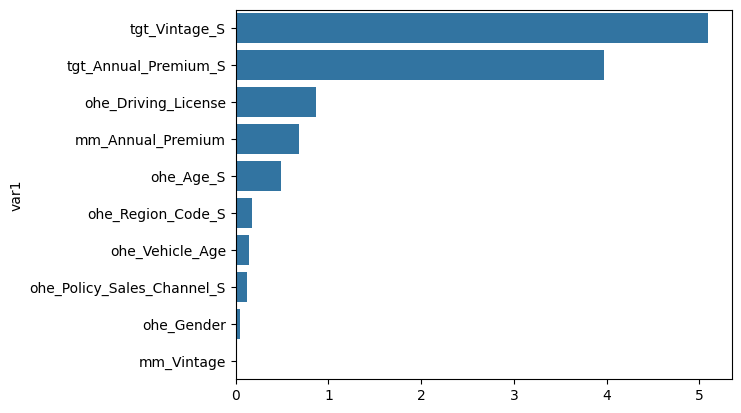

In [35]:
s_coef = result['model_result'][0]['coef'][0]
s_vars = dproc.split_preprocess_var(s_coef.index.to_series(), pd_procs.df_var.index)['var1']
s_coef.abs().groupby(s_vars).mean().sort_values(ascending=False).pipe(lambda x: sns.barplot(y=x.index, x=x.values))
plt.show()

In [36]:
hparams = {
    'model_params': {'n_estimators': 100, 'learning_rate': 0.3, 'max_depth': 7},
    'X_num': ['Annual_Premium', 'Vintage', 'Age'], 
    'X_cat': ['Annual_Premium_S', 'Vintage_S', 'Policy_Sales_Channel_S', 'Age_S', 'Vehicle_Age', 'Region_Code_S', 
              'Gender', 'Driving_License'],
}

result = sc.cache_result(
    'CB2', 
    lambda : sgml.cv(df_train_sub, ss,  hparams, config, cb_adapter, task_type='GPU', 
                     result_proc=[sgml.cb_learning_result, partial(sgml.gb_shap_learning_result, df=df_train.sample(frac=0.1)), sgml.cb_interaction_importance])
)
result['valid_scores'], result['train_scores']

([0.7465477823401424], [0.7538082001402384])

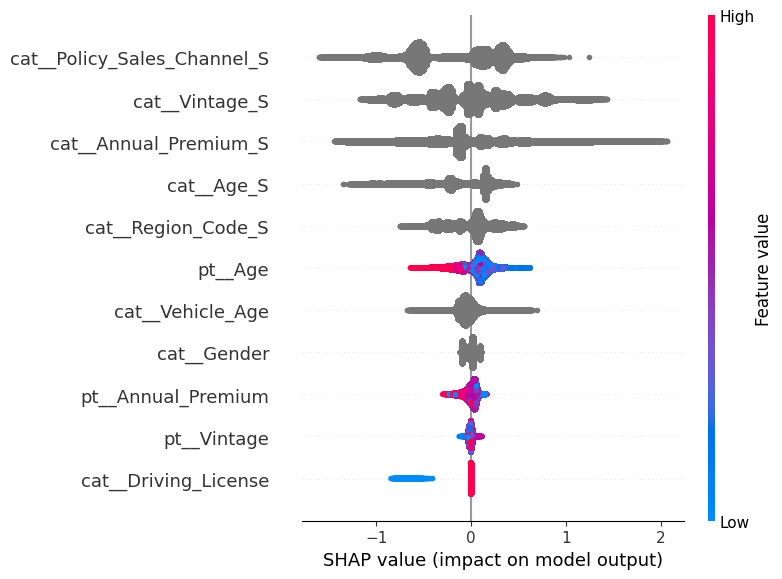

In [37]:
shap.summary_plot(result['model_result'][1]['shap_values'], result['model_result'][1]['X'])

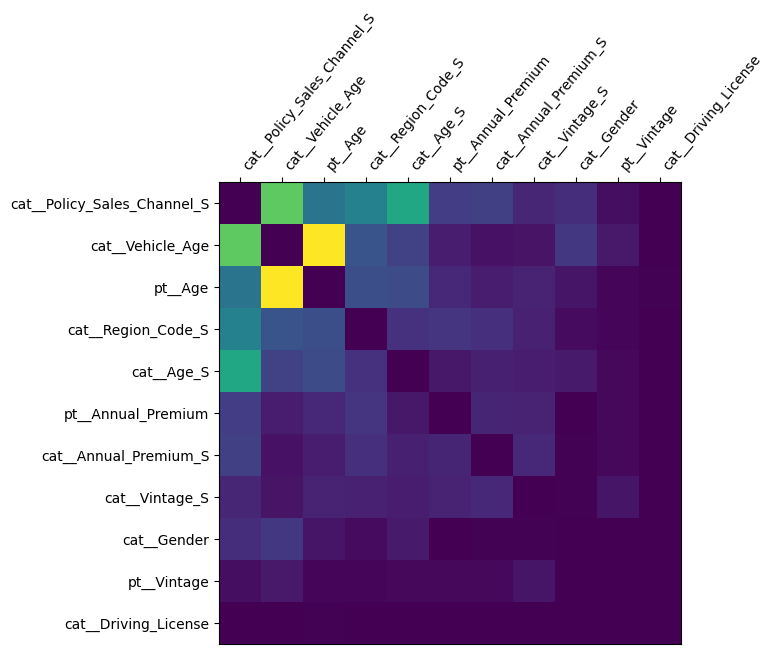

In [38]:
interaction_matrix = np.abs(result['model_result'][1]['shap_interaction_values']).sum(0)
for i in range(interaction_matrix.shape[0]):
    interaction_matrix[i, i] = 0
inds = np.argsort(-interaction_matrix.sum(0))[:20]
sorted_ia_matrix = interaction_matrix[inds, :][:, inds]
plt.figure(figsize=(10, 6))
plt.imshow(sorted_ia_matrix)
plt.yticks(
    range(sorted_ia_matrix.shape[0]),
    result['model_result'][1]['X'].columns[inds],
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(sorted_ia_matrix.shape[0]),
    result['model_result'][1]['X'].columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

## ~(Previously_Insured, Vehicle_Damage  == ('0', 'Yes'))`

In [40]:
df_train_sub = df_train.loc[~((df_train['Previously_Insured'] == '0') & (df_train['Vehicle_Damage'] == 'Yes'))]
hparams = {
    'model_params': {},
    'X_tgt': ['Vintage_S', 'Annual_Premium_S'],
    'X_mm': ['Vintage', 'Annual_Premium'], 
    'X_ohe': ['Previously_Insured', 'Vehicle_Damage', 'Policy_Sales_Channel_S', 'Age_S', 'Vehicle_Age', 'Region_Code_S', 'Gender', 'Driving_License'],
    'ohe': {'drop': 'first', 'handle_unknown': 'ignore'},
    'tgt': {}
}

result_2 = sc.cache_result(
    'LR3', 
    lambda : sgml.cv(df_train_sub, ss, hparams, config, lr_adapter, result_proc=[sgml.lr_learning_result])
)
result_2['valid_scores'], result_2['train_scores']

([0.9404704826692577], [0.9391619989761848])

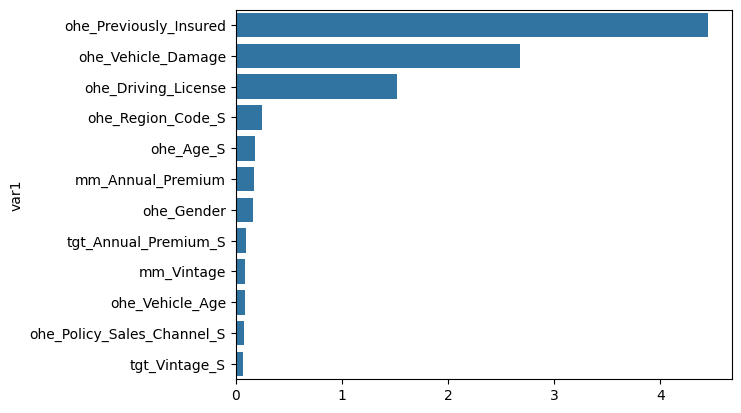

In [42]:
s_coef = result_2['model_result'][0]['coef'][0]
s_vars = dproc.split_preprocess_var(s_coef.index.to_series(), pd_procs.df_var.index)['var1']
s_coef.abs().groupby(s_vars).mean().sort_values(ascending=False).pipe(lambda x: sns.barplot(y=x.index, x=x.values))
plt.show()

In [43]:
hparams = {
    'model_params': {'n_estimators': 100, 'learning_rate': 0.3, 'max_depth': 7},
    'X_num': ['Annual_Premium', 'Vintage', 'Age'], 
    'X_cat': ['Previously_Insured', 'Vehicle_Damage', 'Annual_Premium_S', 'Vintage_S', 'Policy_Sales_Channel_S', 'Age_S', 'Vehicle_Age', 'Region_Code_S', 
              'Gender', 'Driving_License'],
}

result = sc.cache_result(
    'CB3', 
    lambda : sgml.cv(df_train_sub, ss,  hparams, config, cb_adapter, task_type='GPU', 
                     result_proc=[sgml.cb_learning_result, partial(sgml.gb_shap_learning_result, df=df_train.sample(frac=0.1)), sgml.cb_interaction_importance])
)
result['valid_scores'], result['train_scores']

([0.9482719524545217], [0.9504100085449836])

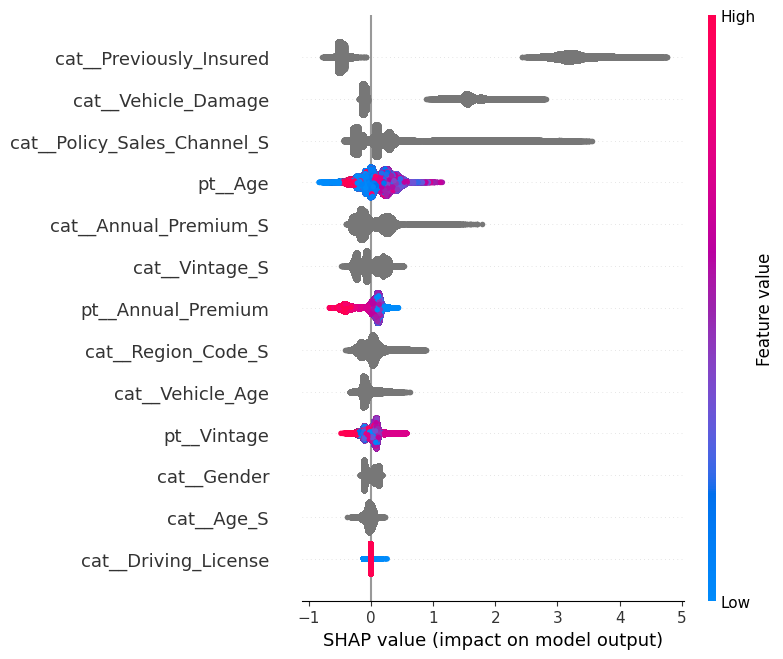

In [44]:
shap.summary_plot(result['model_result'][1]['shap_values'], result['model_result'][1]['X'])

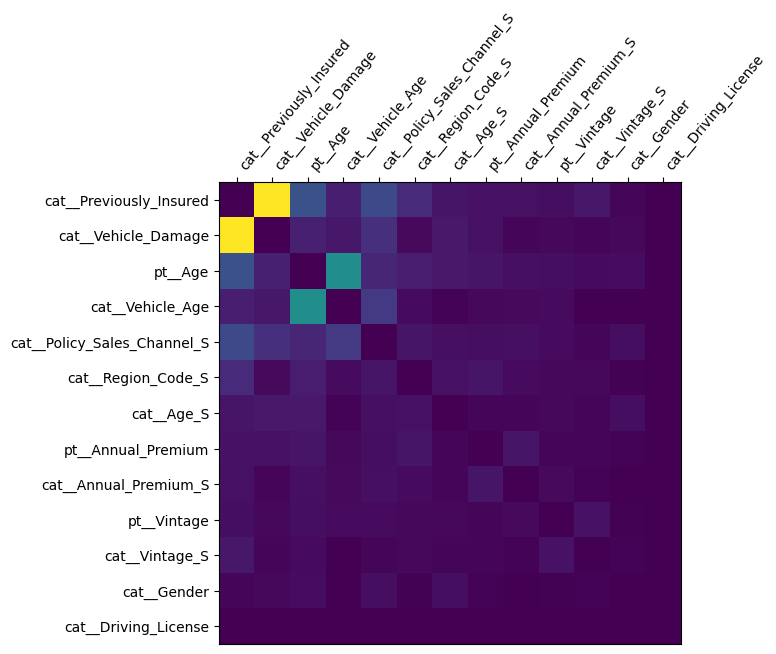

In [45]:
interaction_matrix = np.abs(result['model_result'][1]['shap_interaction_values']).sum(0)
for i in range(interaction_matrix.shape[0]):
    interaction_matrix[i, i] = 0
inds = np.argsort(-interaction_matrix.sum(0))[:20]
sorted_ia_matrix = interaction_matrix[inds, :][:, inds]
plt.figure(figsize=(10, 6))
plt.imshow(sorted_ia_matrix)
plt.yticks(
    range(sorted_ia_matrix.shape[0]),
    result['model_result'][1]['X'].columns[inds],
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(sorted_ia_matrix.shape[0]),
    result['model_result'][1]['X'].columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

## Extracting the properties of features using TargetEncoding

Vehicle_Damage와 Previously_Insured 는 target을 구분하는 핵심변수 입니다. 입력 변수끼리 연관성이 높고, 

특히 이 두 변수와 직간접적으로 밀접한 연관성을 지니고 있습니다. Target에 대한 변수만의 특징을 추출하기 위해 VP의 영향을 제외한

각 변수만의 특징을 추출하기 위해 아래와 같이 Vehicle_Damage와 Previously_Insured와 각 변수간의 결합 속성을 만들고,  

Target 인코딩 값과 Vehicle_Damage와 Previously_Insured 결합 변수의 Target 인코딩 값의 차이를 파생변수로 만들어 각 변수들의 범주값들이 지닌

Target에 대한 영향력만을 추출해봅니다.

In [46]:
df_train['VP'] = dproc.combine_cat(df_train[['Vehicle_Damage', 'Previously_Insured']], '_')
df_train['VPV'] = dproc.combine_cat(df_train[['VP', 'Vehicle_Age']], '_')
df_train['VPA'] = dproc.combine_cat(df_train[['VP', 'Annual_Premium_S']], '_')
df_train['VPVi'] = dproc.combine_cat(df_train[['VP', 'Vintage_S']], '_')
df_train['VPP'] = dproc.combine_cat(df_train[['VP', 'Policy_Sales_Channel_S']], '_')
df_train['VPAg'] = dproc.combine_cat(df_train[['VP', 'Age_S']], '_')
df_train['VPR'] = dproc.combine_cat(df_train[['VP', 'Region_Code_S']], '_')
df_train['VPVP'] = dproc.combine_cat(df_train[['VPV', 'Policy_Sales_Channel_S']], '_')
df_train['VPPAg'] = dproc.combine_cat(df_train[['VPP', 'Age_S']], '_')
df_train['VPPR'] = dproc.combine_cat(df_train[['VPP', 'Region_Code_S']], '_')
df_train['VPVA'] = dproc.combine_cat(df_train[['VPV', 'Annual_Premium_S']], '_')
s_cat = dproc.combine_cat(df_train[['VPAg', 'Annual_Premium_S']], '_')
c_type = pd.CategoricalDtype(['etc'] + s_cat.value_counts().pipe(lambda x: x.loc[x >= 10]).index.tolist())
df_train['VPAgA'] = dproc.rearrange_cat(s_cat, c_type, lambda c, v: 0 if v not in c else v, use_set=True)

In [47]:
from sklearn.preprocessing import TargetEncoder

def tgt_proc(df):
    tgt_list = ['VP', 'VPV', 'VPVi', 'VPA', 'VPAg', 'VPP', 'VPR', 'VPVP', 'VPPAg', 'VPPR', 'VPVA', 'VPAgA']
    tgt_agg = {
        i : list()
        for i in tgt_list
    }
    for train_idx, valid_idx in skf.split(df, df[target]):
        df_cv_train, df_valid = df.iloc[train_idx], df.iloc[valid_idx]
        for i in tgt_list:
            tgt_agg[i].append(
                pd.Series(
                    TargetEncoder(random_state=123).fit(df_cv_train[[i]], df_cv_train[target]).transform(df_valid[[i]])[:, 0],
                    index = df_valid[i].index
                )
            )
    return {
        i: pd.concat(tgt_agg[i])
        for i in tgt_list
    }
tgt = sc.cache_result(
    'tgt', lambda : tgt_proc(df_train), 1
)
df_train['D1'] = tgt['VPVi'] - tgt['VP']
df_train['D2'] = tgt['VPA'] - tgt['VP']
df_train['D3'] = tgt['VPAg'] - tgt['VP']
df_train['D4'] = tgt['VPP'] - tgt['VP']
df_train['D5'] = tgt['VPR'] - tgt['VP']
df_train['D6'] = tgt['VPVP'] - tgt['VPV']
df_train['D7'] = tgt['VPPAg'] - tgt['VPP']
df_train['D8'] = tgt['VPPR'] - tgt['VPP']
df_train['D9'] = tgt['VPVA'] - tgt['VPV']
df_train['D10'] = tgt['VPAgA'] - tgt['VPAg']

In [48]:
df_train[['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10']].corr()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10
D1,1.000000,0.048321,0.052059,0.053390,0.041780,0.036007,0.033700,0.025172,0.041591,-0.000817
D2,0.048321,1.000000,0.136438,0.153143,0.150278,0.077366,0.063047,0.074181,0.845871,0.227072
D3,0.052059,0.136438,1.000000,0.515288,0.216697,0.180530,0.666269,0.052385,0.072969,-0.256442
D4,0.053390,0.153143,0.515288,1.000000,0.348587,0.604234,-0.001120,-0.000847,0.047062,-0.117056
D5,0.041780,0.150278,0.216697,0.348587,1.000000,0.180637,0.028639,0.651896,0.088186,-0.039945
D6,0.036007,0.077366,0.180530,0.604234,0.180637,1.000000,0.107132,0.007259,0.085501,-0.046513
D7,0.033700,0.063047,0.666269,-0.001120,0.028639,0.107132,1.000000,0.059887,0.084450,-0.178494
D8,0.025172,0.074181,0.052385,-0.000847,0.651896,0.007259,0.059887,1.000000,0.069671,-0.008256
D9,0.041591,0.845871,0.072969,0.047062,0.088186,0.085501,0.084450,0.069671,1.000000,0.238782
D10,-0.000817,0.227072,-0.256442,-0.117056,-0.039945,-0.046513,-0.178494,-0.008256,0.238782,1.000000


In [49]:
hparams = {
    'model_params': {'n_estimators': 50, 'learning_rate': 0.3, 'max_depth': 9},
    'X_num': ['Annual_Premium', 'Vintage', 'Age', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10'], 
    'X_cat': ['Annual_Premium_S', 'Vintage_S', 'Vehicle_Damage', 'Previously_Insured', 'Policy_Sales_Channel_S', 'Age_S', 'Vehicle_Age', 'Region_Code_S', 
              'Gender', 'Driving_License'],
}

result = sc.cache_result(
    'CB4', 
    lambda : sgml.cv(df_train, ss,  hparams, config, cb_adapter, task_type='GPU', 
                     result_proc=[sgml.cb_learning_result, partial(sgml.gb_shap_learning_result, df=df_train.sample(frac=0.1)), sgml.cb_interaction_importance])
)
result['valid_scores'], result['train_scores']

([0.8918309317388948], [0.8923428236241272])

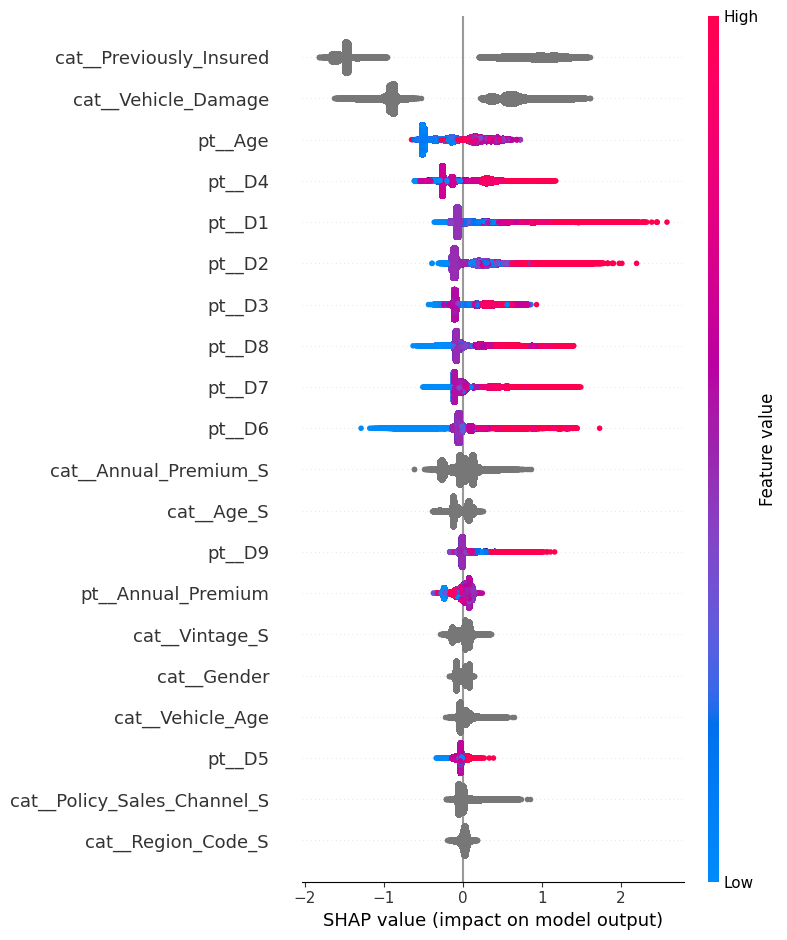

In [50]:
shap.summary_plot(result['model_result'][1]['shap_values'], result['model_result'][1]['X'])

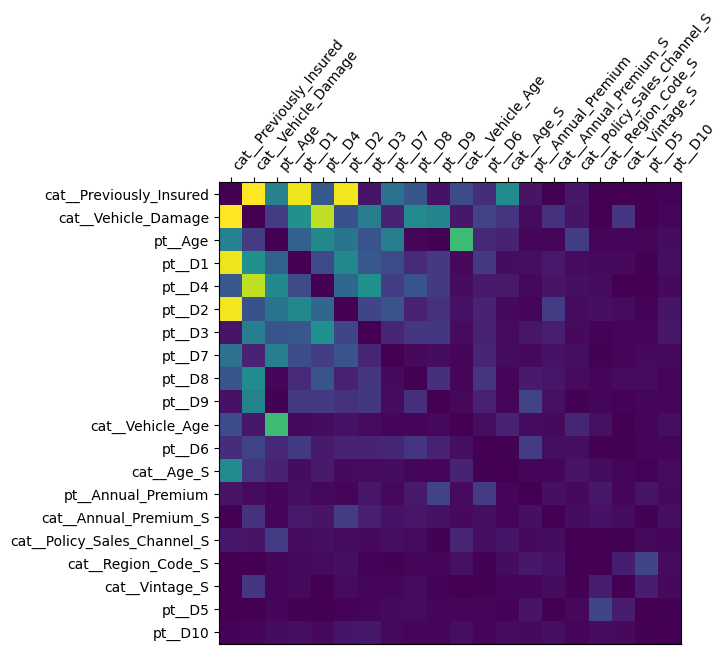

In [51]:
interaction_matrix = np.abs(result['model_result'][1]['shap_interaction_values']).sum(0)
for i in range(interaction_matrix.shape[0]):
    interaction_matrix[i, i] = 0
inds = np.argsort(-interaction_matrix.sum(0))[:20]
sorted_ia_matrix = interaction_matrix[inds, :][:, inds]
plt.figure(figsize=(10, 6))
plt.imshow(sorted_ia_matrix)
plt.yticks(
    range(sorted_ia_matrix.shape[0]),
    result['model_result'][1]['X'].columns[inds],
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(sorted_ia_matrix.shape[0]),
    result['model_result'][1]['X'].columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

In [52]:
hparams = {
    'model_params': {'n_estimators': 50, 'learning_rate': 0.3, 'max_depth': 9},
    'lda': {'X_mm': ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9'], 'X_ohe': ['Vehicle_Damage', 'Previously_Insured'], 
            'ohe': {'drop': 'first', 'sparse_output': False}},
    'X_num': ['Annual_Premium', 'Age', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10'], 
    'X_cat': ['Annual_Premium_S', 'Vehicle_Damage', 'Previously_Insured', 'Policy_Sales_Channel_S', 'Age_S', 'Vehicle_Age', 'Region_Code_S', 
              'Gender', 'Driving_License'],
}

result = sc.cache_result(
    'CB5', 
    lambda : sgml.cv(df_train, ss,  hparams, config, cb_adapter, task_type='GPU', 
                     result_proc=[sgml.cb_learning_result, partial(sgml.gb_shap_learning_result, df=df_train.sample(frac=0.1)), sgml.cb_interaction_importance])
)
result['valid_scores'], result['train_scores']

([0.8922398434480363], [0.8927351498132742])

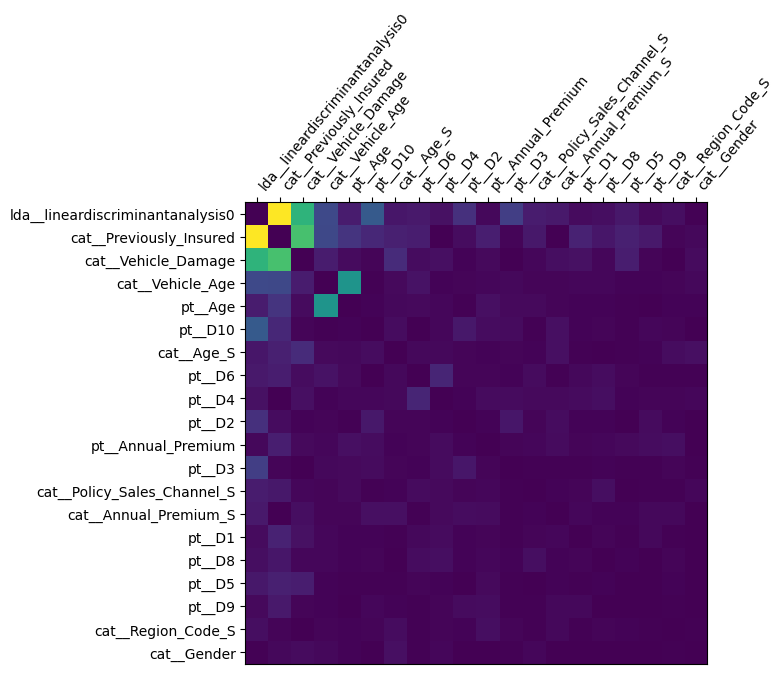

In [54]:
interaction_matrix = np.abs(result['model_result'][1]['shap_interaction_values']).sum(0)
for i in range(interaction_matrix.shape[0]):
    interaction_matrix[i, i] = 0
inds = np.argsort(-interaction_matrix.sum(0))[:20]
sorted_ia_matrix = interaction_matrix[inds, :][:, inds]
plt.figure(figsize=(10, 6))
plt.imshow(sorted_ia_matrix)
plt.yticks(
    range(sorted_ia_matrix.shape[0]),
    result['model_result'][1]['X'].columns[inds],
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(sorted_ia_matrix.shape[0]),
    result['model_result'][1]['X'].columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

In [56]:
hparams = {
    'model_params': {},
    'X_tgt': ['Vintage_S', 'Annual_Premium_S'],
    'X_mm': ['Annual_Premium', 'Vintage', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10'], 
    'X_ohe': ['Vehicle_Damage', 'Previously_Insured', 'Policy_Sales_Channel_S', 'Age_S', 'Vehicle_Age', 'Region_Code_S', 
              'Gender', 'Driving_License'],
    'ohe': {'drop': 'first', 'handle_unknown': 'ignore'},
}

result = sc.cache_result(
    'LR4', 
    lambda : sgml.cv(df_train, ss, hparams, config, lr_adapter, 
                     result_proc=[sgml.lr_learning_result])
)

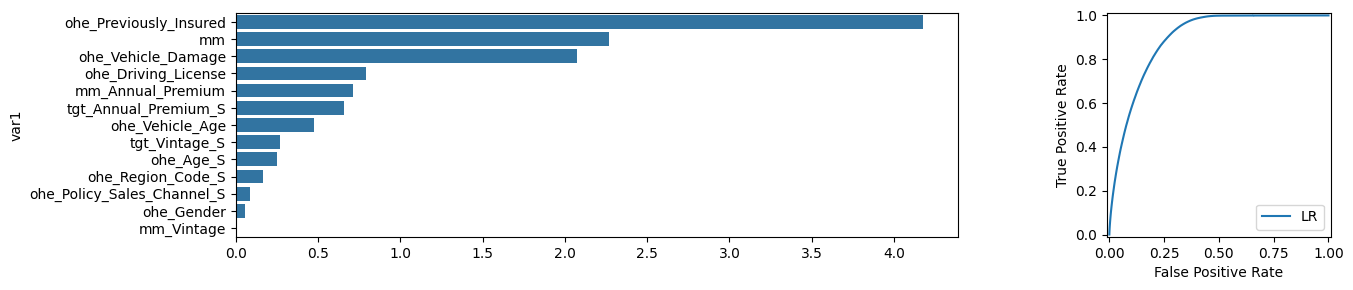

([0.889907612102364], [0.8899131229659705])

In [64]:
from sklearn.metrics import RocCurveDisplay, roc_curve
s_coef = result['model_result'][0]['coef'][0]
s_vars = dproc.split_preprocess_var(s_coef.index.to_series(), pd_procs.df_var.index)['var1']
fig, axes = plt.subplots(1, 2, figsize=(16, 3))
s_coef.abs().groupby(s_vars).mean().sort_values(ascending=False).pipe(lambda x: sns.barplot(y=x.index, x=x.values, ax=axes[0]))
fpr, tpr, _ = roc_curve(df_train.loc[result['valid_prd'].index, target], result['valid_prd'])
RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name='LR').plot(ax=axes[1])
plt.tight_layout()
plt.show()
result['valid_scores'], result['train_scores']

# LightGBM

In [65]:
hparams = {
    'model_params': {'n_estimators': 100, 'learning_rate': 0.1, 'num_leaves': 127},
    'X_tgt': ['Annual_Premium_S'],
    'X_num': ['Annual_Premium', 'Age', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10'], 
    'X_cat': ['Vehicle_Damage', 'Previously_Insured', 'Policy_Sales_Channel_S', 'Age_S', 'Vehicle_Age', 'Region_Code_S', 
              'Gender', 'Driving_License'],
}

result = sc.cache_result(
    'LGB1', 
    lambda : sgml.cv(df_train, ss,  hparams, config, lgb_adapter)
)
result['valid_scores'], result['train_scores']

Round:   0%|          | 0/100 [00:00<?, ?it/s]

([0.8922066426544127], [0.8940307992640296])

# NN

In [66]:
import tensorflow as tf
import sgnn
from functools import partial

class ResponseModel(tf.keras.Model):
    def __init__(self, emb_cols, cont_cols, f_size, left_layers, right_layers, top_layers , **argv):
        super().__init__()
        if emb_cols != None:
            self.emb_layers = {
                v: tf.keras.layers.Embedding(c, s, name=v) for v, c, s in emb_cols
            }
            self.emb_cc = tf.keras.layers.Concatenate(axis=-1)
            if left_layers != None:
                self.left_model = tf.keras.models.Sequential([
                    tf.keras.layers.Dense(**params) for params in left_layers
                ])
                self.right_model = tf.keras.models.Sequential([
                    tf.keras.layers.Dense(**params) for params in right_layers
                ])
                self.mul = tf.keras.layers.Multiply()
                self.left_slice_layer_1 = tf.keras.layers.Lambda(lambda x: x[:, :f_size])
                self.left_slice_layer_2 = tf.keras.layers.Lambda(lambda x: x[:, f_size:])
                self.right_slice_layer_1 = tf.keras.layers.Lambda(lambda x: x[:, :f_size])
                self.right_slice_layer_2 = tf.keras.layers.Lambda(lambda x: x[:, f_size:])
            else:
                self.left_model = None
        else:
            self.emb_layers = None
        self.top_cc = tf.keras.layers.Concatenate(axis=-1)
        self.top_model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(**params) for params in top_layers
        ])
        self.f_size = f_size
        self.cont_cols = cont_cols
        self.sigmoid = tf.keras.layers.Activation('sigmoid')

    def __call__(self, X):
        if self.emb_layers != None:
            X_emb = self.emb_cc([tf.squeeze(v(X[k]), axis=-2) for k, v in self.emb_layers.items()])
            if self.left_model !=None:
                X_left = self.left_model(X_emb)
                X_right = self.right_model(X_emb)
                X_left_1 = self.left_slice_layer_1(X_left)
                X_left_2 = self.left_slice_layer_2(X_left)
                
                X_right_1 = self.right_slice_layer_1(X_right)
                X_right_2 = self.right_slice_layer_2(X_right)
                X_mul = self.mul([X_left_1, X_right_1])
                cc_list = [X_left_2, X_right_2, X_mul]
            else:
                cc_list = [X_emb]
        else:
            cc_list = list()
        if self.cont_cols != None:
            cc_list.append(X[self.cont_cols])
        if len(cc_list) == 1:
            return self.sigmoid(
                self.top_model(cc_list[0])
            )
        else:
            return self.sigmoid(
                self.top_model(self.top_cc(cc_list))
            )

def to_tf_dataset(X, Y=None, sample_weights=None, cont=[], cat=[]):
    d = {}
    for i, n in enumerate(cat):
        d[n] = np.expand_dims(X[:, i], axis=-1)
    if len(cont) > 0:
        d['Continous'] =  X[:, (i + 1):]
    
    if Y is None:
        return tf.data.Dataset.from_tensor_slices(d)
    else:
        if type(Y) == pd.Series:
            if sample_weights is None:
                return tf.data.Dataset.from_tensor_slices((d, Y.values))
            else:
                return tf.data.Dataset.from_tensor_slices((d, Y.values, sample_weights.values))
        else:
            if sample_weights is None:
                return tf.data.Dataset.from_tensor_slices((d, Y))
            else:
                return tf.data.Dataset.from_tensor_slices((d, Y, sample_weights))

def nn_cat_param(df, name, size):
    return name, len(df[name].cat.categories), size

nn_adapter = sgnn.NNAdapter(
    sgnn.NNClassifier, 
    to_tf_dataset=partial(to_tf_dataset, 
            cont=['mm__{}'.format(i) for i in ['Annual_Premium', 'Vintage', 'Age', 'Driving_License']], 
            cat= ['Annual_Premium_S', 'Vintage_S', 'Vehicle_Damage', 'Previously_Insured', 'Policy_Sales_Channel_S', 'Age_S', 'Vehicle_Age', 'Region_Code_S', 
                'Gender', 'VA_Age']
    )
)

2025-01-01 13:54:06.677769: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-01 13:54:06.909602: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-01 13:54:07.703683: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [67]:
X_nn_emb = [
    ('Annual_Premium_S', 3), ('Vintage_S', 2), ('Vehicle_Damage', 1), ('Previously_Insured', 1), ('Policy_Sales_Channel_S', 2), ('Age_S', 2), ('Vehicle_Age', 1), ('Region_Code_S', 2), 
    ('Gender', 1)
]
hparams = {
    'model_params': {
        'model': ResponseModel,
        'model_params': {
            'emb_cols': [
                nn_cat_param(df_train, v, n) for v, n in X_nn_emb
            ], 
            'cont_cols':  'Continous',
            'f_size':  16, 
            'left_layers': [
                {'units': 32, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
                {'units': 32, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
                {'units': 32, 'kernel_initializer': 'glorot_uniform'}]
            , 
            'right_layers': [
                {'units': 32, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
                {'units': 32, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
                {'units': 16, 'kernel_initializer': 'glorot_uniform'}
            ], 
            'top_layers': [
                {'units': 32, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
                {'units': 16, 'activation': 'relu', 'kernel_initializer': 'he_uniform'}, 
                {'units': 1, 'kernel_initializer': 'glorot_uniform'}
            ]
        },
        'batch_size': 512,
        'shuffle_size': 204800,
        'optimizer': ('Adam', {'learning_rate': 0.001}),
        'epochs': 3
    },
    'X_mm': ['Annual_Premium', 'Vintage', 'Age', 'Driving_License', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6'], 
    'X_cat': ['Annual_Premium_S', 'Vintage_S', 'Vehicle_Damage', 'Previously_Insured', 'Policy_Sales_Channel_S', 'Age_S', 'Vehicle_Age', 'Region_Code_S', 
              'Gender'],
}

result = sc.cache_result(
    'nn1', 
    lambda : sgml.cv(df_train, ss,  hparams, config, nn_adapter)
)
result['valid_scores'], result['train_scores']

2025-01-01 13:54:18.685912: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-01 13:54:18.802675: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Step:   0%|          | 0/17977 [00:00<?, ?it/s]

([0.8904189877208502], [0.8973302217868394])

In [68]:
def get_combine_proc(df):
    s_cat = dproc.combine_cat(df_train[['Vehicle_Damage', 'Previously_Insured', 'Age_S', 'Annual_Premium_S']], '_')
    c_type = pd.CategoricalDtype(['etc'] + s_cat.value_counts().pipe(lambda x: x.loc[x >= 10]).index.tolist())
    return lambda x: pd.concat([
        dproc.combine_cat(x[['Vehicle_Damage', 'Previously_Insured']], '_').rename('VP'),
        dproc.combine_cat(x[['Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age']], '_').rename('VPV'),
        dproc.combine_cat(x[['Vehicle_Damage', 'Previously_Insured', 'Annual_Premium_S']], '_').rename('VPA'),
        dproc.combine_cat(x[['Vehicle_Damage', 'Previously_Insured', 'Vintage_S']], '_').rename('VPVi'),
        dproc.combine_cat(x[['Vehicle_Damage', 'Previously_Insured', 'Policy_Sales_Channel_S']], '_').rename('VPP'),
        dproc.combine_cat(x[['Vehicle_Damage', 'Previously_Insured', 'Age_S']], '_').rename('VPAg'),
        dproc.combine_cat(x[['Vehicle_Damage', 'Previously_Insured', 'Region_Code_S']], '_').rename('VPR'),
        dproc.combine_cat(x[['Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age', 'Policy_Sales_Channel_S']], '_').rename('VPVP'),
        dproc.combine_cat(x[['Vehicle_Damage', 'Previously_Insured', 'Policy_Sales_Channel_S', 'Age_S']], '_').rename('VPPAg'),
        dproc.combine_cat(x[['Vehicle_Damage', 'Previously_Insured', 'Policy_Sales_Channel_S', 'Region_Code_S']], '_').rename('VPPR'),
        dproc.combine_cat(x[['Vehicle_Damage', 'Previously_Insured', 'Vehicle_Age', 'Annual_Premium_S']], '_').rename('VPVA'),
        dproc.rearrange_cat(s_cat, c_type, lambda c, v: 0 if v not in c else v, use_set=True).rename('VPAgA')
    ], axis=1)
combine_proc = get_combine_proc(df_train)

In [69]:
# Machine Learning 과정에서 도출한 변수를 추가합니다.
df_train = pd_procs.put_proc(
    'combine', df_train, 
    [(combine_proc, {
        'VP': 'Vehicle_Damage, Previously_Insured를 결합합니다.',
        'VPV': 'Vehicle_Damage, Previously_Insured, Vehicle_Age를 결합합니다.',
        'VPA': 'Vehicle_Damage, Previously_Insured, Annual_Premium_S를 결합합니다.',
        'VPVi': 'Vehicle_Damage, Previously_Insured, Vintage_S를 결합합니다.',
        'VPP': 'Vehicle_Damage, Previously_Insured, Policy_Sales_Channel_S를 결합합니다.',
        'VPAg': 'Vehicle_Damage, Previously_Insured, Age_S를 결합합니다.',
        'VPR': 'Vehicle_Damage, Previously_Insured, Region_Code_S를 결합합니다.',
        'VPVP': 'Vehicle_Damage, Previously_Insured, Vehicle_Age, Policy_Sales_Channel_S를 결합합니다.',
        'VPPAg': 'Vehicle_Damage, Previously_Insured, Policy_Sales_Channel_S, Age_S를 결합합니다.',
        'VPPR': 'Vehicle_Damage, Previously_Insured, Policy_Sales_Channel_S, Region_Code_S를 결합합니다.',
        'VPVA': 'Vehicle_Damage, Previously_Insured, Vehicle_Age, Annual_Premium_S를 결합합니다.',
        'VPAgA': 'Vehicle_Damage, Previously_Insured, Age_S, Annual_Premium_S를를 결합합니다.',
    })]
)

In [70]:
pd_procs.save()